In [ ]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 55.4 MB/s eta 0:00:00


In [ ]:
import os
import time
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from jiwer import wer, cer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pickle
import re
import math

In [ ]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [ ]:
# Check if GPU is available
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {DEVICE}')

Using device: cuda


In [ ]:
# Create output directory
from google.colab import drive
drive.mount('/content/drive')

OUTPUT_DIR = '/content/drive/MyDrive/output_transformer_char/'
os.makedirs(OUTPUT_DIR, exist_ok=True)

Mounted at /content/drive


In [ ]:
# # Create output directory
# OUTPUT_DIR = './output_transformer_char/'
# if not os.path.exists(OUTPUT_DIR):
#     os.makedirs(OUTPUT_DIR)

In [ ]:
# Paths for saving/loading
DATASET_PATH = './exportStatements.xlsx'
VOCAB_PATH = os.path.join(OUTPUT_DIR, 'char_vocab.pkl')
PREPROCESSED_DATA_PATH = os.path.join(OUTPUT_DIR, 'preprocessed_data_char.pkl')
BEST_MODEL_PATH = os.path.join(OUTPUT_DIR, 'best_transformer_model_char.pt')
BEST_CER_MODEL_PATH = os.path.join(OUTPUT_DIR, 'best_transformer_model_cer.pt')
LOSS_PLOT_PATH = os.path.join(OUTPUT_DIR, 'transformer_loss_plot_char.png')
ER_PLOT_PATH = os.path.join(OUTPUT_DIR, 'er_plot.png')

In [ ]:
# Load the dataset
df = pd.read_excel(DATASET_PATH)

In [ ]:
# Check for missing values in 'inFormalForm' and 'FormalForm'
print("Missing values in 'inFormalForm':", df['inFormalForm'].isnull().sum())
print("Missing values in 'FormalForm':", df['FormalForm'].isnull().sum())

# Drop rows with missing values in 'inFormalForm' and 'FormalForm'
initial_length = len(df)
df = df.dropna(subset=['inFormalForm', 'FormalForm']).reset_index(drop=True)
final_length = len(df)

df['inFormalForm'] = df['inFormalForm'].astype(str)
df['FormalForm'] = df['FormalForm'].astype(str)

print(f"Dropped {initial_length - final_length} rows due to missing values.")

Missing values in 'inFormalForm': 0
Missing values in 'FormalForm': 1
Dropped 1 rows due to missing values.


In [ ]:
def clean_persian_text(text):
    # 1. Keep only Persian letters, English letters, digits, whitespace, ZWNJ
    text = re.sub(r"[^\u0600-\u06FFa-zA-Z0-9\u06F0-\u06F9\u0660-\u0669\u200c\s]", " ", text)
    # Remove leftover Persian punctuations explicitly (، ؛ ؟)
    text = re.sub(r"[،؛؟]", " ", text)
    # Remove Arabic diacritics (harakat)
    arabic_diacritics = r"[\u064B-\u065F\u0670\u06D6-\u06ED]"
    text = re.sub(arabic_diacritics, "", text)

    # 2. Normalize Persian/Arabic digits to Western digits
    persian_digits = "۰۱۲۳۴۵۶۷۸۹"
    arabic_digits = "٠١٢٣٤٥٦٧٨٩"
    for p, a, e in zip(persian_digits, arabic_digits, "0123456789"):
        text = text.replace(p, e).replace(a, e)

    # 3. Separate numbers stuck to Persian/English letters
    text = re.sub(r"(\d+)(?=[\u0600-\u06FFa-zA-Z])", r"\1 ", text)  # digit before letter
    text = re.sub(r"([\u0600-\u06FFa-zA-Z])(?=\d+)", r"\1 ", text)  # letter before digit

    # 4. Remove underscores
    text = re.sub(r"_+", "", text)

    # 5. Normalize spaces
    text = re.sub(r"\s+", " ", text).strip()

    return text

In [ ]:
df['inFormalForm'] = df['inFormalForm'].apply(clean_persian_text)
df['FormalForm'] = df['FormalForm'].apply(clean_persian_text)

In [ ]:
# Split data into training, validation, and test sets (80%, 10%, 10%)
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=SEED)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=SEED)

In [ ]:
# Build character vocabulary from training data
if not os.path.exists(VOCAB_PATH):
    print('Building character vocabulary...')
    all_text = ''.join(train_df['inFormalForm'].tolist() + train_df['FormalForm'].tolist())
    chars = sorted(list(set(all_text)))
    # Add special tokens
    special_tokens = ['<pad>', '<unk>', '<s>', '</s>']
    char2idx = {char: idx + len(special_tokens) for idx, char in enumerate(chars)}
    for idx, token in enumerate(special_tokens):
        char2idx[token] = idx
    idx2char = {idx: char for char, idx in char2idx.items()}

    # Save vocabulary
    with open(VOCAB_PATH, 'wb') as f:
        pickle.dump({'char2idx': char2idx, 'idx2char': idx2char}, f)
    print('Character vocabulary built and saved.')
else:
    print('Loading existing character vocabulary...')
    with open(VOCAB_PATH, 'rb') as f:
        vocab = pickle.load(f)
        char2idx = vocab['char2idx']
        idx2char = vocab['idx2char']

Loading existing character vocabulary...


In [ ]:
# Special token IDs
PAD_IDX = char2idx['<pad>']
UNK_IDX = char2idx['<unk>']
BOS_IDX = char2idx['<s>']
EOS_IDX = char2idx['</s>']

PAD_IDX, UNK_IDX, BOS_IDX, EOS_IDX

(0, 1, 2, 3)

In [ ]:
# Maximum sequence length (based on dataset)
def get_max_len(df_list):
    max_len = 0
    for df in df_list:
        lengths_src = df['inFormalForm'].apply(lambda x: len(x) + 2)  # +2 for BOS and EOS
        lengths_trg = df['FormalForm'].apply(lambda x: len(x) + 2)
        max_len = max(max_len, lengths_src.max(), lengths_trg.max())
    return max_len

MAX_LEN = get_max_len([train_df, val_df, test_df])
MAX_LEN

406

In [ ]:
# Check if preprocessed data exists
if not os.path.exists(PREPROCESSED_DATA_PATH):
    print('Preprocessing data...')
    # Preprocess and tokenize all sentences
    def preprocess_data(df, char2idx, max_len=MAX_LEN):
        src_texts = df['inFormalForm'].tolist()
        trg_texts = df['FormalForm'].tolist()
        src_sequences = []
        trg_sequences = []
        for src, trg in zip(src_texts, trg_texts):
            src_chars = list(src)
            trg_chars = list(trg)
            src_ids = [BOS_IDX] + [char2idx.get(c, UNK_IDX) for c in src_chars] + [EOS_IDX]
            trg_ids = [BOS_IDX] + [char2idx.get(c, UNK_IDX) for c in trg_chars] + [EOS_IDX]
            # Pad or truncate sequences
            src_ids = src_ids[:max_len] + [PAD_IDX] * max(0, max_len - len(src_ids))
            trg_ids = trg_ids[:max_len] + [PAD_IDX] * max(0, max_len - len(trg_ids))
            src_sequences.append(src_ids)
            trg_sequences.append(trg_ids)
        return src_sequences, trg_sequences

    # Tokenize and preprocess data
    train_src, train_trg = preprocess_data(train_df, char2idx)
    val_src, val_trg = preprocess_data(val_df, char2idx)
    test_src, test_trg = preprocess_data(test_df, char2idx)

    # Save preprocessed data
    with open(PREPROCESSED_DATA_PATH, 'wb') as f:
        pickle.dump({
            'train_src': train_src,
            'train_trg': train_trg,
            'val_src': val_src,
            'val_trg': val_trg,
            'test_src': test_src,
            'test_trg': test_trg,
            'MAX_LEN': MAX_LEN
        }, f)
    print('Preprocessed data saved.')
else:
    print('Loading preprocessed data...')
    # Load preprocessed data
    with open(PREPROCESSED_DATA_PATH, 'rb') as f:
        data = pickle.load(f)
        train_src = data['train_src']
        train_trg = data['train_trg']
        val_src = data['val_src']
        val_trg = data['val_trg']
        test_src = data['test_src']
        test_trg = data['test_trg']
        MAX_LEN = data['MAX_LEN']

Loading preprocessed data...


In [ ]:
# Prepare datasets
class TranslationDataset(Dataset):
    def __init__(self, src_sequences, trg_sequences):
        self.src_sequences = src_sequences
        self.trg_sequences = trg_sequences

    def __len__(self):
        return len(self.src_sequences)

    def __getitem__(self, idx):
        src_ids = torch.tensor(self.src_sequences[idx], dtype=torch.long)
        trg_ids = torch.tensor(self.trg_sequences[idx], dtype=torch.long)
        return src_ids, trg_ids

In [ ]:
# Collate function to create masks and pad sequences
def collate_fn(batch, pad_idx):
    src_batch, trg_batch = zip(*batch)
    src_batch = torch.nn.utils.rnn.pad_sequence(src_batch, padding_value=pad_idx, batch_first=True)
    trg_batch = torch.nn.utils.rnn.pad_sequence(trg_batch, padding_value=pad_idx, batch_first=True)
    return src_batch, trg_batch

In [ ]:
# Create datasets and dataloaders
batch_size = 32

train_dataset = TranslationDataset(train_src, train_trg)
val_dataset = TranslationDataset(val_src, val_trg)
test_dataset = TranslationDataset(test_src, test_trg)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: collate_fn(x, PAD_IDX))
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=lambda x: collate_fn(x, PAD_IDX))
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=lambda x: collate_fn(x, PAD_IDX))

In [ ]:
# Function to generate subsequent masks for target
def generate_square_subsequent_mask(sz):
    mask = torch.triu(torch.ones((sz, sz), device=DEVICE), diagonal=1).bool()
    return mask.float().masked_fill(mask, float('-inf'))

In [ ]:
# Function to create padding masks
def create_mask(src, tgt, pad_idx):
    src_seq_len = src.size(1)
    tgt_seq_len = tgt.size(1)

    src_mask = torch.zeros((src_seq_len, src_seq_len), device=DEVICE).float()
    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)

    src_padding_mask = (src == pad_idx)
    tgt_padding_mask = (tgt == pad_idx)

    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [ ]:
# Transformer Model Definition
class Seq2SeqTransformer(nn.Module):
    def __init__(self, num_encoder_layers, num_decoder_layers, emb_size,
                 nhead, src_vocab_size, tgt_vocab_size, dim_feedforward=512,
                 dropout=0.1, max_len=MAX_LEN, pad_idx=PAD_IDX):
        super(Seq2SeqTransformer, self).__init__()
        self.src_vocab_size = src_vocab_size
        self.tgt_vocab_size = tgt_vocab_size
        self.emb_size = emb_size
        self.pad_idx = pad_idx
        self.max_len = max_len

        # Token embedding layers
        self.src_embedding = nn.Embedding(src_vocab_size, emb_size, padding_idx=pad_idx)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, emb_size, padding_idx=pad_idx)

        # Learned positional embeddings
        self.src_pos_embedding = nn.Embedding(max_len, emb_size)
        self.tgt_pos_embedding = nn.Embedding(max_len, emb_size)

        # Transformer
        self.transformer = nn.Transformer(d_model=emb_size, nhead=nhead,
                                          num_encoder_layers=num_encoder_layers,
                                          num_decoder_layers=num_decoder_layers,
                                          dim_feedforward=dim_feedforward,
                                          dropout=dropout)

        # Output layer
        self.generator = nn.Linear(emb_size, tgt_vocab_size)

    def forward(self, src, tgt, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, memory_key_padding_mask):
        # src and tgt shape: [batch_size, seq_len]
        src_seq_len = src.size(1)
        tgt_seq_len = tgt.size(1)
        src_positions = torch.arange(0, src_seq_len, device=src.device).unsqueeze(0).expand(src.size(0), -1)
        tgt_positions = torch.arange(0, tgt_seq_len, device=tgt.device).unsqueeze(0).expand(tgt.size(0), -1)

        # Embed and encode source
        src_tok = self.src_embedding(src) * math.sqrt(self.emb_size)
        src_emb = src_tok + self.src_pos_embedding(src_positions)
        # Embed and encode target
        tgt_tok = self.tgt_embedding(tgt) * math.sqrt(self.emb_size)
        tgt_emb = tgt_tok + self.tgt_pos_embedding(tgt_positions)

        # Transformer
        output = self.transformer(
            src_emb.transpose(0, 1), tgt_emb.transpose(0, 1),
            src_mask=src_mask, tgt_mask=tgt_mask, memory_mask=None,
            src_key_padding_mask=src_padding_mask,
            tgt_key_padding_mask=tgt_padding_mask,
            memory_key_padding_mask=memory_key_padding_mask
        )

        output = output.transpose(0,1)
        logits = self.generator(output)
        return logits

    def encode(self, src, src_mask, src_key_padding_mask=None):
        src_seq_len = src.size(1)
        src_positions = torch.arange(0, src_seq_len, device=src.device).unsqueeze(0).expand(src.size(0), -1)
        src_tok = self.src_embedding(src) * math.sqrt(self.emb_size)
        src_emb = src_tok + self.src_pos_embedding(src_positions)
        return self.transformer.encoder(
            src_emb.transpose(0, 1),
            mask=src_mask,
            src_key_padding_mask=src_key_padding_mask
        )

    def decode(self, tgt, memory, tgt_mask, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        tgt_seq_len = tgt.size(1)
        tgt_positions = torch.arange(0, tgt_seq_len, device=tgt.device).unsqueeze(0).expand(tgt.size(0), -1)
        tgt_tok = self.tgt_embedding(tgt) * math.sqrt(self.emb_size)
        tgt_emb = tgt_tok + self.tgt_pos_embedding(tgt_positions)
        return self.transformer.decoder(
            tgt_emb.transpose(0, 1), memory,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            memory_key_padding_mask=memory_key_padding_mask
        )

In [ ]:
# Initialize model parameters
VOCAB_SIZE = len(char2idx)
SRC_VOCAB_SIZE = VOCAB_SIZE
TGT_VOCAB_SIZE = VOCAB_SIZE

# Hyperparameters
num_encoder_layers = 3
num_decoder_layers = 3
emb_size = 256
nhead = 8
dim_feedforward = 256
dropout = 0.1 


model = Seq2SeqTransformer(num_encoder_layers, num_decoder_layers, emb_size,
                           nhead, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE,
                           dim_feedforward, dropout, MAX_LEN, PAD_IDX).to(DEVICE)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
# Initialize optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [ ]:
def evaluate_wer(model, dataloader, idx2char, max_batches=None):
    model.eval()
    cer_scores = []
    wer_scores = []
    batches_processed = 0

    with torch.no_grad():
        for src, trg in dataloader:
            src = src.to(DEVICE)
            trg = trg.to(DEVICE)
            device = src.device

            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, trg[:, :-1], PAD_IDX)

            output = model(src, trg[:, :-1], src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)
            output = output.argmax(dim=-1)

            trg_out = trg[:, 1:].tolist()  # Remove first token (<s>) for target
            output = output.tolist()

            for pred_ids, trg_ids in zip(output, trg_out):
                # Remove PAD and special tokens
                pred_ids = [idx for idx in pred_ids if idx not in [PAD_IDX, EOS_IDX, BOS_IDX]]
                trg_ids = [idx for idx in trg_ids if idx not in [PAD_IDX, EOS_IDX, BOS_IDX]]

                pred_sentence = ''.join([idx2char.get(idx, '') for idx in pred_ids])
                trg_sentence = ''.join([idx2char.get(idx, '') for idx in trg_ids])

                cer_score = cer(trg_sentence, pred_sentence)
                wer_score = wer(trg_sentence, pred_sentence)

                cer_scores.append(cer_score)
                wer_scores.append(wer_score)

            batches_processed += 1
            if max_batches and batches_processed >= max_batches:
                break

    avg_cer = np.mean(cer_scores)
    avg_wer = np.mean(wer_scores)
    return avg_cer, avg_wer

In [ ]:
# === Paths ===
CHECKPOINT_PATH = "/content/drive/MyDrive/output_transformer_char/checkpoint.pth"
LOG_FILE = "/content/drive/MyDrive/output_transformer_char/train_log.txt"

# === Settings ===
N_EPOCHS = 100
patience = 5
counter = 0
best_valid_loss = float('inf')
best_valid_cer = float('inf')

# === Resume variables ===
start_epoch = 1

# ==== Load checkpoint if available ====
if os.path.exists(CHECKPOINT_PATH):
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_valid_loss = checkpoint['best_valid_loss']
    best_valid_cer = checkpoint['best_valid_cer']
    counter = checkpoint['counter']

    if os.path.exists(LOG_FILE):
      with open(LOG_FILE, "r") as f:
          print(f.read())  # prints all previous logs

    resume_msg = f"--- Resuming training from epoch {start_epoch} ---"
    print("\n" + resume_msg + "\n")
    with open(LOG_FILE, "a") as f:
        f.write("\n" + resume_msg + "\n")

train_losses = []
valid_losses = []

train_wers = []
valid_wers = []
train_cers = []
valid_cers = []

# ==== Training Loop ====
for epoch in range(start_epoch, N_EPOCHS + 1):
    start_time = time.time()

    # Training
    model.train()
    epoch_train_loss = 0
    train_bar = tqdm(train_loader, desc=f'Training Epoch {epoch}/{N_EPOCHS}')
    for src, trg in train_bar:
        src = src.to(DEVICE)
        trg = trg.to(DEVICE)

        # Create masks
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, trg[:, :-1], PAD_IDX)

        optimizer.zero_grad()
        output = model(src, trg[:, :-1], src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)

        trg_out = trg[:, 1:]
        output = output.reshape(-1, TGT_VOCAB_SIZE)
        trg_out = trg_out.reshape(-1)

        loss = criterion(output, trg_out)
        loss.backward()

        optimizer.step()

        epoch_train_loss += loss.item()

    with open(LOG_FILE, "a") as f:
        f.write(str(train_bar) + "\n")

    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)


    # Validation
    model.eval()
    epoch_valid_loss = 0
    with torch.no_grad():
        val_bar = tqdm(val_loader, desc=f'Validation Epoch {epoch}/{N_EPOCHS}')
        for src, trg in val_bar:
            src = src.to(DEVICE)
            trg = trg.to(DEVICE)

            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, trg[:, :-1], PAD_IDX)

            output = model(src, trg[:, :-1], src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)

            trg_out = trg[:, 1:]

            output = output.reshape(-1, TGT_VOCAB_SIZE)
            trg_out = trg_out.reshape(-1)

            loss = criterion(output, trg_out)
            epoch_valid_loss += loss.item()

    with open(LOG_FILE, "a") as f:
        f.write(str(val_bar) + "\n")

    epoch_valid_loss /= len(val_loader)
    valid_losses.append(epoch_valid_loss)

    # Evaluate WER
    valid_cer, valid_wer = evaluate_wer(model, val_loader, idx2char)
    valid_wers.append(valid_wer)
    valid_cers.append(valid_cer)

    # === Log metrics ===
    log_text = (
        f"\n\tTrain Loss: {epoch_train_loss:.3f}\n"
        f"\tValid Loss: {epoch_valid_loss:.3f}\n"
        f"\tValid WER: {valid_wer:.4f}\n"
        f"\tValid CER: {valid_cer:.4f}\n"
    )
    print(log_text)
    with open(LOG_FILE, "a") as f:
        f.write(log_text)

    # === Save best models ===
    # Early stopping check
    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        msg = f"Validation loss improved. Model saved to {BEST_MODEL_PATH}."
        print(msg)
        with open(LOG_FILE, "a") as f:
            f.write(msg + "\n")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            msg = "Early stopping triggered."
            print(msg)
            with open(LOG_FILE, "a") as f:
                f.write(msg + "\n")
            break

    if valid_cer < best_valid_cer:
        best_valid_cer = valid_cer
        torch.save(model.state_dict(), BEST_CER_MODEL_PATH)
        msg = f"Validation CER improved. Model saved to {BEST_CER_MODEL_PATH}."
        print(msg)
        with open(LOG_FILE, "a") as f:
            f.write(msg + "\n")

    # === Save checkpoint ===
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_valid_loss': best_valid_loss,
        'best_valid_cer': best_valid_cer,
        'counter': counter
    }, CHECKPOINT_PATH)


    # === Epoch timing ===

    end_time = time.time()
    epoch_mins, epoch_secs = divmod(int(end_time - start_time), 60)
    time_msg = f"Epoch: {epoch:02} | Time: {epoch_mins}m {epoch_secs}s"

    print(time_msg)
    with open(LOG_FILE, "a") as f:
        f.write(time_msg + "\n")

Training Epoch 1/100:   0%|          | 0/1251 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6041: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6041: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
Validation Epoch 1/100: 100%|██████████| 157/157 [00:14<00:00, 11.18it/s]

	Train Loss: 2.138
	Valid Loss: 1.772
	Valid WER: 6.3526
	Valid CER: 7.2584
Validation loss improved. Model saved to /content/drive/MyDrive/output_transformer_char/best_transformer_model_char.pt.
Validation CER improved. Model saved to /content/drive/MyDrive/output_transformer_char/best_transformer_model_cer.pt.
Epoch: 01 | Time: 6m 30s

Validation Epoch 2/100: 100%|██████████| 157/157 [00:14<00:00, 11.18it/s]

	Train Loss: 1.780
	Valid Loss: 1.608
	Valid WER:

Training Epoch 88/100:   0%|          | 0/1251 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6041: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6041: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
Validation Epoch 88/100: 100%|██████████| 157/157 [00:13<00:00, 11.31it/s]



	Train Loss: 0.166
	Valid Loss: 0.155
	Valid WER: 0.2535
	Valid CER: 0.7954

Epoch: 88 | Time: 6m 22s


Validation Epoch 89/100: 100%|██████████| 157/157 [00:13<00:00, 11.25it/s]



	Train Loss: 0.167
	Valid Loss: 0.154
	Valid WER: 0.2397
	Valid CER: 0.6885

Early stopping triggered.


In [ ]:
# Initialize empty lists
train_losses = []
valid_losses = []
valid_wers = []
valid_cers = []

# Parse log file
if os.path.exists(LOG_FILE):
    with open(LOG_FILE, "r") as f:
        for line in f:
            if line.strip().startswith("Train Loss:"):
                train_losses.append(float(line.strip().split()[-1]))
            elif line.strip().startswith("Valid Loss:"):
                valid_losses.append(float(line.strip().split()[-1]))
            elif line.strip().startswith("Valid WER:"):
                valid_wers.append(float(line.strip().split()[-1]))
            elif line.strip().startswith("Valid CER:"):
                valid_cers.append(float(line.strip().split()[-1]))

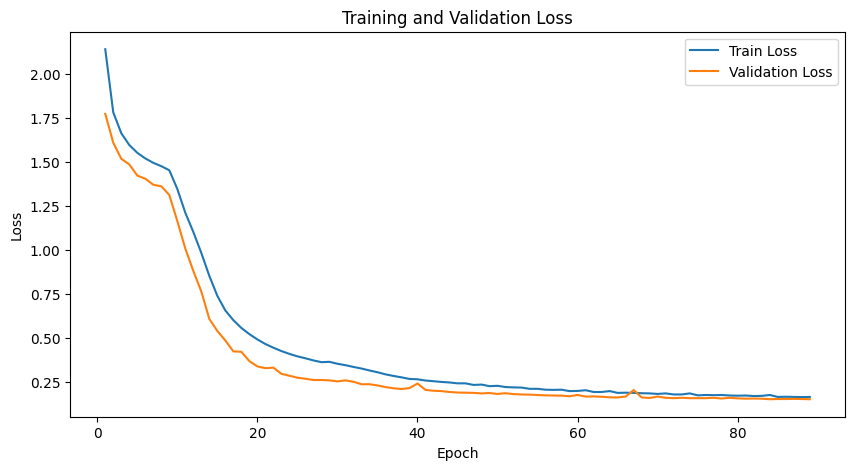

Loss plot saved to /content/drive/MyDrive/output_transformer_char/transformer_loss_plot_char.png.


In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.savefig(LOSS_PLOT_PATH)
plt.show()
print(f'Loss plot saved to {LOSS_PLOT_PATH}.')

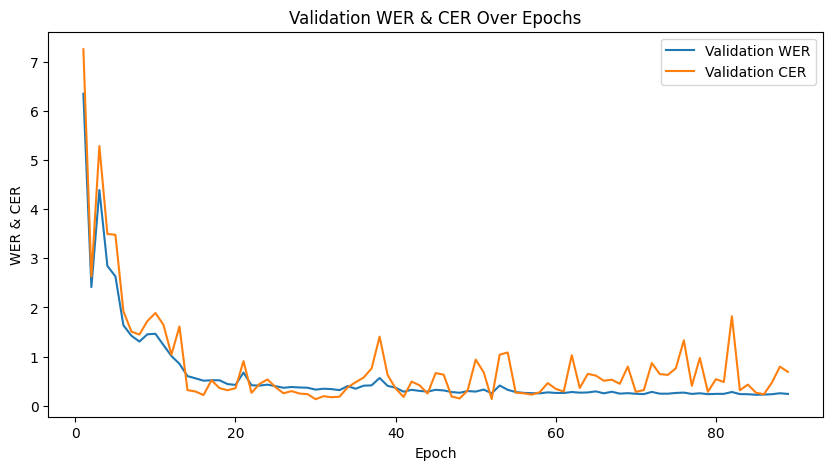

Plot saved to /content/drive/MyDrive/output_transformer_char/er_plot.png.


In [ ]:
# Plot validation CER & WER over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(valid_wers) + 1), valid_wers, label='Validation WER')
plt.plot(range(1, len(valid_cers) + 1), valid_cers, label='Validation CER')
plt.xlabel('Epoch')
plt.ylabel('WER & CER')
plt.legend()
plt.title('Validation WER & CER Over Epochs')
plt.savefig(ER_PLOT_PATH)

plt.show()
print(f'Plot saved to {ER_PLOT_PATH}.')

In [ ]:
def greedy_decode_inference(model, src, src_mask, max_len, bos_idx):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)
    src_padding_mask = (src == PAD_IDX)

    memory = model.encode(src, src_mask, src_key_padding_mask=src_padding_mask)
    ys = torch.ones(1, 1).fill_(bos_idx).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        tgt_mask = generate_square_subsequent_mask(ys.size(1)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask, tgt_key_padding_mask=None, memory_key_padding_mask=src_padding_mask)
        out = out.transpose(0,1)
        prob = model.generator(out[:, -1])
        next_word = torch.argmax(prob, dim=1).item()
        ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
        if next_word == EOS_IDX:
            break
    return ys

In [ ]:
def translate_sentence(sentence, model, char2idx, idx2char, device, max_len=MAX_LEN, decoding_strategy='greedy'):
    model.eval()
    chars = list(sentence)
    tokens = [BOS_IDX] + [char2idx.get(c, UNK_IDX) for c in chars] + [EOS_IDX]
    tokens = tokens[:max_len]
    src = torch.tensor(tokens, dtype=torch.long).unsqueeze(0).to(device)
    src_mask = torch.zeros((src.shape[1], src.shape[1]), device=device).float()
    if decoding_strategy == 'greedy':
        tgt_tokens = greedy_decode_inference(model, src, src_mask, max_len, BOS_IDX).flatten()
    else:
        raise ValueError("Invalid decoding strategy")
    tgt_tokens = tgt_tokens.cpu().numpy()
    # Remove BOS token
    tgt_tokens = tgt_tokens[1:]
    # Stop at EOS token
    if EOS_IDX in tgt_tokens:
        eos_index = np.where(tgt_tokens == EOS_IDX)[0][0]
        tgt_tokens = tgt_tokens[:eos_index]
    translation = ''.join([idx2char.get(idx, '') for idx in tgt_tokens if idx not in [PAD_IDX, BOS_IDX, EOS_IDX, UNK_IDX]])
    return translation

In [ ]:
def evaluate_and_save(model, df, src_sequences, trg_sequences, char2idx, idx2char, file_name):
    model.eval()
    predictions = []
    cer_scores = []
    wer_scores = []

    for src_ids, trg_ids in tqdm(zip(src_sequences, trg_sequences), total=len(src_sequences), desc=f'Evaluating {file_name}'):
        src_sentence = ''.join([idx2char[idx] for idx in src_ids if idx not in [BOS_IDX, EOS_IDX, PAD_IDX]])
        trg_sentence = ''.join([idx2char[idx] for idx in trg_ids if idx not in [BOS_IDX, EOS_IDX, PAD_IDX]])

        pred_sentence = translate_sentence(src_sentence, model, char2idx, idx2char, DEVICE)
        predictions.append(pred_sentence)
        cer_score = cer(trg_sentence, pred_sentence)
        wer_score = wer(trg_sentence, pred_sentence)
        cer_scores.append(cer_score)
        wer_scores.append(wer_score)

    results_df = pd.DataFrame({
        'Source': df['inFormalForm'],
        'Target': df['FormalForm'],
        'Prediction': predictions,
        'CER': cer_scores,
        'WER': wer_scores
    })

    results_df = results_df.sort_values(by=['CER', 'WER'], ascending=[True, True])

    results_path = os.path.join(OUTPUT_DIR, file_name)
    results_df.to_csv(results_path, index=False)
    avg_cer = np.mean(cer_scores)
    avg_wer = np.mean(wer_scores)
    print(f'Results saved to {results_path}')
    print(f'Average CER: {avg_cer:.4f}')
    print(f'Average WER: {avg_wer:.4f}')
    return results_df

In [ ]:
model.load_state_dict(torch.load(BEST_MODEL_PATH))
print('Best model loaded.')

print('Evaluating on training data...')
train_results = evaluate_and_save(model, train_df, train_src, train_trg, char2idx, idx2char, 'train_results_char_transformer.csv')

print('Evaluating on validation data...')
val_results = evaluate_and_save(model, val_df, val_src, val_trg, char2idx, idx2char, 'val_results_char_transformer.csv')

print('Evaluating on test data...')
test_results = evaluate_and_save(model, test_df, test_src, test_trg, char2idx, idx2char, 'test_results_char_transformer.csv')

Best model loaded.
Evaluating on training data...


Evaluating train_results_char_transformer.csv: 100%|██████████| 40008/40008 [3:05:13<00:00,  3.60it/s]


Results saved to /content/drive/MyDrive/output_transformer_char/train_results_char_transformer.csv
Average CER: 0.1381
Average WER: 0.2288
Evaluating on validation data...


Evaluating val_results_char_transformer.csv: 100%|██████████| 5001/5001 [23:38<00:00,  3.53it/s]


Results saved to /content/drive/MyDrive/output_transformer_char/val_results_char_transformer.csv
Average CER: 0.1527
Average WER: 0.2579
Evaluating on test data...


Evaluating test_results_char_transformer.csv: 100%|██████████| 5002/5002 [23:22<00:00,  3.57it/s]

Results saved to /content/drive/MyDrive/output_transformer_char/test_results_char_transformer.csv
Average CER: 0.1544
Average WER: 0.2611


In [ ]:
model.load_state_dict(torch.load(BEST_CER_MODEL_PATH))
print('Best CER model loaded.')

print('Evaluating on training data using best CER model...')
train_results = evaluate_and_save(model, train_df, train_src, train_trg, char2idx, idx2char, 'train_results_best_cer.csv')

print('Evaluating on validation data using best CER model...')
val_results = evaluate_and_save(model, val_df, val_src, val_trg, char2idx, idx2char, 'val_results_best_cer.csv')

print('Evaluating on test data using best CER model...')
test_results = evaluate_and_save(model, test_df, test_src, test_trg, char2idx, idx2char, 'test_results_best_cer.csv')

Best CER model loaded.
Evaluating on training data using best CER model...


Evaluating train_results_best_cer.csv:   0%|          | 0/40008 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6041: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(
Evaluating train_results_best_cer.csv: 100%|██████████| 40008/40008 [3:07:17<00:00,  3.56it/s]


Results saved to /content/drive/MyDrive/output_transformer_char/train_results_best_cer.csv
Average CER: 0.1903
Average WER: 0.3351
Evaluating on validation data using best CER model...


Evaluating val_results_best_cer.csv: 100%|██████████| 5001/5001 [23:03<00:00,  3.61it/s]


Results saved to /content/drive/MyDrive/output_transformer_char/val_results_best_cer.csv
Average CER: 0.1935
Average WER: 0.3436
Evaluating on test data using best CER model...


Evaluating test_results_best_cer.csv: 100%|██████████| 5002/5002 [22:38<00:00,  3.68it/s]

Results saved to /content/drive/MyDrive/output_transformer_char/test_results_best_cer.csv
Average CER: 0.1966
Average WER: 0.3504
